In [1]:
include("SplineBasisConstruction.jl");

# Spline Basis Construction

## Introduction

A [spline](https://en.wikipedia.org/wiki/Spline_(mathematics) ) is a piecewise polynomial function, formed by joining together several polynomial segments with specified continuities at the breakpoints.  Splines are used in computer-aided design, computer graphics, and higher-order finite element analysis.  If you've seen or used workflows that look like this, you've used splines:

<img alt="A spline in Inkscape" src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.stack.imgur.com%2Fm2Kph.jpg&f=1&nofb=1" width="600px" />

Under the hood, splines are represented using a basis.  When you drag the control points of a spline (the circles in the above image), you are changing the contributions of each basis function.  In order for the spline to have the desired continuity at the breakpoints, this basis must be constructed with the correct continuity.  In addition, there are other properties that the basis must posess in order to be useful for design.  These properties are summarized in the following table:

<!-- | Property | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Math &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description |
| :-------- | :-------- | :-------- |
| Partition of unity | $\sum_A N_A(e,\xi ) = 1 \quad e \in 1,...,n_e;\quad \xi \in [0,1]$ | The sum of all basis functions evaluated at any point in the domain is one. |
| Positivity | $N_A(e,\xi) \geq 0 \quad e \in 1,...,n_e;\quad \xi \in [0,1]$ | The basis functions are all non-negative over the entire domain. |
| Local Support | | Each basis function is nonzero on the smallest possible number of contiguous cells. | -->

| Property | Description |
| :-------- | :-------- |
| Partition of unity | The sum of all basis functions evaluated at any point in the domain is one. |
| Positivity | The basis functions are all non-negative over the entire domain. |
| Local Support | Each basis function is nonzero on the smallest possible number of contiguous cells. |


These properties make dragging a control point for a spline cause an intuitive change in the spline itself.  In other words, the spline "follows" the control points.  This notebook will discuss the construction of a basis for a spline that has these desired properties.

## Problem Definition

Splines may be defined over a set of "elements"; each element is the domain of one of the polynomial segments.  The spline is then a map from an element id, coordinate pair to the real numbers.  The element ids run from 1 to $n_e$, and the polynomial argument on each element $\xi\in[0,1]$.  The spline map may therefore be written as

$$
N : 1,...,n_e \times [0,1] \rightarrow {\rm I\!R},
$$

or in terms of its basis $\{N_A\}_{A=1}^{n_b}$ (where $n_b$ is the number of basis functions) as

$$
N( e, \xi ) = \sum_A d_A N_A(e,\xi) \quad e\in1,...,n_e, \quad \xi \in [0,1],
$$

where $d_A \in {\rm I\!R}, \quad A = 1,...,n_b$ are the control points. The spline may also map to other spaces (e.g. ${\rm I\!R}^2$, as in the figure above) by expanding the basis functions with control points from the desired space.

The problem under consideration is this: Given a desired polynomial degree on each element and a desired continuity between each pair of neighboring elements, construct the basis $\{N_A\}_{A=1}^{n_b}$.

### Polynomial bases

To build the basis for the entire spline domain, we must first start with bases for each polynomial element.  The spline bases will be built as a linear combination of these basis functions, with appropriate constraints to enforce the continuity between elements.  One basis for the space of polynomials of degree at most $p$ are the Bernstein polynomials.  The Bernstein polynomials of degree $p$ are defined as 
$$
B_i^p(\xi) = {p \choose i}(1-\xi)^{p-i}\xi^i, \quad i=0,...,p.
$$

and are shown for $p=1,2,3,4$ here:

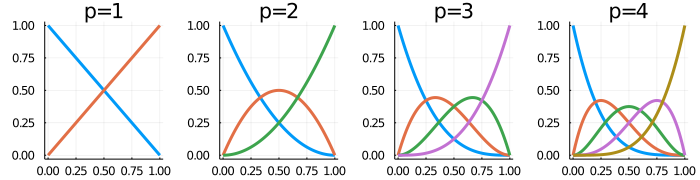

In [2]:
b = [ Plots.plot( [ bernstein( p, i ) for i in 0:p ], 0:0.01:1, legend = false ) for p in 1:4 ]
plt = Plots.plot( b[1], b[2], b[3], b[4],
    title = ["p=1" "p=2" "p=3" "p=4"],
    legend = false, layout = (1,4),
    lw = 3, size = [700, 180] )

As an example, a spline with three elements, of degree 2, 3, and 1, respectively, has the following set of Bernstein bases on it: 

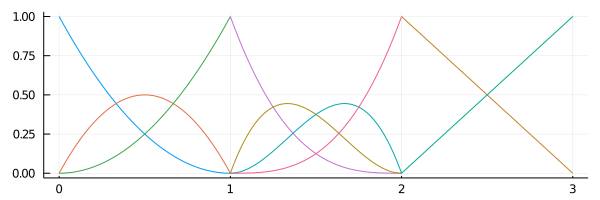

In [3]:
mesh = Mesh( [2,3,1], [] );
plt = Plots.plot( legend = false, size = [600, 200] );
plotLocalBases!( plt, mesh )

These Bernstein basis functions are numbered in the spline context based on the location of their maximum, from left to right, and are denoted simply as $B_i(\xi)$.  We will denote the number of Bernstein functions on the mesh as
$$
m = \sum_{e=1}^{n_e}p_e+1.
$$


A Bernstein basis function may be considered to be zero outside of the element over which it is defined.  Each spline basis function may be written as a linear combination of these Bernstein functions as

$$
N_A(e,\xi) = \sum_{i=1}^{m} C_{Ai} B_i(e,\xi).
$$

The continuity constraints between the elements allow us to solve for the coefficients $C_{Ai}$.


### Continuity constraints

At each interface between neighboring elements $e_j$ and $e_{j+1}$, the prescribed continuity is denoted as $k_j$.  In order to enforce $C^{k_j}$ continuity the following relationships must hold:

$$
\sum_i C_{Ai}B_i(e_j,1) = \sum_i C_{Ai}B_i(e_{j+1},0) \quad A = 1,...,n_b;\\
\sum_i \frac{d}{d\xi} C_{Ai}B_i(e_j,1) = \sum_i \frac{d}{d\xi} C_{Ai}B_i(e_{j+1},0) \quad A = 1,...,n_b;\\
\vdots\\
\sum_i \frac{d^{k_j}}{d\xi^{k_j}} C_{Ai}B_i(e_j,1) = \sum_i \frac{d^{k_j}}{d\xi^{k_j}} C_{Ai}B_i(e_{j+1},0) \quad A = 1,...,n_b;
$$

These constraints may be rewritten as a null space problem as follows:

$$
\begin{bmatrix}
B_1(1,1)-B_1(2,0)& B_2(1,1)-B_2(2,0) & \cdots & B_m(1,1)-B_m(2,0) \\
B_1'(1,1)-B_1'(2,0)& B_2'(1,1)-B_2'(2,0) & \cdots & B_m'(1,1)-B_m'(2,0) \\
\vdots \\
B_1^{(k_1)}(1,1)-B_1^{(k_1)}(2,0)& B_2^{(k_1)}(1,1)-B_2^{(k_1)}(2,0) & \cdots & B_m^{(k_1)}(1,1)-B_m^{(k_1)}(2,0) \\
B_1(2,1)-B_1(3,0)& B_2(2,1)-B_2(3,0) & \cdots & B_m(2,1)-B_m(3,0) \\
B_1'(2,1)-B_1'(3,0)& B_2'(2,1)-B_2'(3,0) & \cdots & B_m'(2,1)-B_m'(3,0) \\
\vdots \\
B_1^{(k_2)}(2,1)-B_1^{(k_2)}(3,0)& B_2^{(k_2)}(2,1)-B_2^{(k_2)}(3,0) & \cdots & B_m^{(k_2)}(2,1)-B_m^{(k_2)}(3,0) \\
\vdots \\
B_1(n_e-1,1)-B_1(n_e,0)& B_2(n_e-1,1)-B_2(n_e,0) & \cdots & B_m(n_e-1,1)-B_m(n_e,0) \\
B_1'(n_e-1,1)-B_1'(n_e,0)& B_2'(n_e-1,1)-B_2'(n_e,0) & \cdots & B_m'(n_e-1,1)-B_m'(n_e,0) \\
\vdots \\
B_1^{(k_{n_e-1})}(n_e-1,1)-B_1^{(k_{n_e-1})}(n_e,0)& B_2^{(k_{n_e-1})}(n_e-1,1)-B_2^{(k_{n_e-1})}(n_e,0) & \cdots & B_m^{(k_{n_e-1})}(n_e-1,1)-B_m^{(k_{n_e-1})}(n_e,0) \\
\end{bmatrix}
\begin{pmatrix}
C_{1}\\
C_{2}\\
\vdots \\
C_{m}\\
\end{pmatrix}
=
\begin{pmatrix}
0\\
0\\
\vdots\\
0
\end{pmatrix}
$$

Note that because each Bernstein function is zero over most of the elements, and because of the [root multiplicity property of Berstein polynomials](https://en.wikipedia.org/wiki/Bernstein_polynomial#Properties), the matrix will often be mostly zeros.  For example, on the mesh pictured in the polynomial basis section, with $k_1=1$ and $k_2=0$, the following matrix encodes the continuity constraints:

In [10]:
mesh = Mesh( [2 3 1], [1 0] )
S = buildS( mesh )
display(S)

3×9 Array{Float64,2}:
 0.0   0.0  1.0  -1.0  -0.0  -0.0  -0.0   0.0   0.0
 0.0  -2.0  2.0   3.0  -3.0  -0.0  -0.0   0.0   0.0
 0.0   0.0  0.0   0.0   0.0   0.0   1.0  -1.0  -0.0

## Solving the Nullspace problem

There are plenty of methods for solving nullspace problems, including built in functions in Numpy and Julia.  However, these methods do not create a basis with the desired properties listed in the table above.  For example, if we compute the nullspace of the matrix $S$ that we just computed, we get basis functions that are negative on some areas of the domain, basis functions that span the entire domain, and the basis as a whole does not satisfy the partition of unity:

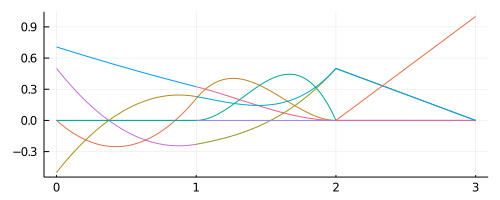

In [12]:
N = LinearAlgebra.nullspace( S )
plt = Plots.plot( legend = false, size=[500,200] )
plotSplineBasis!( plt, mesh, N )
plt

Instead, for each basis function we wish to compute we can take the approach of finding the smallest number of rows of the matrix which will create a nullspace of dimension one, and solve for that nullspace.  This is equivalent to finding the smallest number of Bernstein functions that must be combined to create a spline basis function, and the resulting spline basis functions will satisfy the Local Support property.  Based on the properties of the continuity constraints, the following algorithms will find these minimum sets of Bernstein functions, returning them as a pair of integers, $\{i_{\rm min}, i_{\rm max} \}$:

In [15]:
function findSupports( mesh::Mesh )
    function findSupport!( mesh::Mesh, localfunc::LocalFunc, corners=[] )
        # ----- Helper function -----
        # Determines if spline function should extend into next element
        function extendIntoNextCell( curr_localfunc::LocalFunc )
            return curr_localfunc.elem != length( mesh.degrees ) &&
                mesh.degrees[ curr_localfunc.elem ] - curr_localfunc.idx <= mesh.smoothnesses[ curr_localfunc.elem ]
        end

        # ----- Helper function -----
        # Determines how many bernstein coefficients the spline function needs
        # from the next element based on already active smoothness constraints
        function nextCellExtension( curr_localfunc )
            return mesh.smoothnesses[ curr_localfunc.elem ] - ( mesh.degrees[ curr_localfunc.elem ] - curr_localfunc.idx )
        end

        # ------ findSupport function body -----
        curr_localfunc = localfunc
        while extendIntoNextCell( curr_localfunc )
            curr_localfunc = LocalFunc( curr_localfunc.elem + 1, nextCellExtension( curr_localfunc ) )
            append!( corners, localToGlobal( mesh, curr_localfunc ) )
        end

        return [ localToGlobal( mesh, localfunc ) localToGlobal( mesh, curr_localfunc ) ]
    end

    corners = [];
    supports = zeros( Integer, 0, 2 )
    for localfunc in meshLocalFuncs( mesh )
        if localToGlobal( mesh, localfunc ) in corners
            continue
        end
        append!( corners, localToGlobal( mesh, localfunc ) )

        supports = vcat( supports, findSupport!( mesh, localfunc, corners ) )
    end
    return supports
end;

supports = findSupports( mesh )

6×2 Array{Integer,2}:
 1  1
 2  4
 3  5
 6  6
 7  8
 9  9

These indices give us the following sub-matrices:

In [19]:
for row in 1:size( supports, 1 )
    Ssub = S[:,supports[row,1]:supports[row,2]]
    display(Ssub)
end

3×1 Array{Float64,2}:
 0.0
 0.0
 0.0

3×3 Array{Float64,2}:
  0.0  1.0  -1.0
 -2.0  2.0   3.0
  0.0  0.0   0.0

3×3 Array{Float64,2}:
 1.0  -1.0  -0.0
 2.0   3.0  -3.0
 0.0   0.0   0.0

3×1 Array{Float64,2}:
 -0.0
 -0.0
  0.0

3×2 Array{Float64,2}:
 -0.0   0.0
 -0.0   0.0
  1.0  -1.0

3×1 Array{Float64,2}:
  0.0
  0.0
 -0.0

If we remove the zero rows from each matrix, and add an equation requiring the coefficient corresponding to the first column to be 1, we get full rank systems of the form

$$
\begin{bmatrix}
\\
& & S_{\rm sub} & & \\
\\
1&0&0&\cdots&0\\
\end{bmatrix}
\begin{bmatrix}
c
\end{bmatrix}
=
\begin{bmatrix}
0\\
0\\
\vdots \\
0\\
1
\end{bmatrix}
$$

which can be solved by inverting the matrix on the left side.  Finally, once we have this solution for each subset of $S$,  a partition of unity can be achieved by solving the equation

$$
N^Tb=\mathbf{1}
$$

where the columns of $N$ are the solutions of the full-rank systems, using a least-squares solution.  The final normalized basis is found by multiplying each column of $N$ by the corresponding coefficient in $b$.  This is implemented in the code below:

In [22]:
function computeCoefficients( S, support )
    # Remove columns outside support, and any zero rows
    Ssub = S[ vec( mapslices( col -> any( col[ support[1]:support[2] ] .!= 0 ), S, dims = 2 ) ), support[1]:support[2] ]
    # Add the row [ 1 0 0 0 ... ] to the matrix to change nullspace problem into a full-rank system
    Ssub = vcat( Ssub, hcat( [1.0], zeros( 1, length( support[1]:support[2] ) - 1 ) ) )
    # rhs is [ 0 0 ... 0 1 ]'
    b = vcat( zeros( size( Ssub, 1 ) - 1, 1 ), [1.0] )
    # Solve for the coefficients
    coeffs = zeros( size( S, 2 ), 1 )
    coeffs[ support[1]:support[2], 1 ] = Ssub\b
    return coeffs
end


function buildSplineBasis( mesh::Mesh )
    S = buildS( mesh )
    supports = findSupports( mesh )

    n_lf = numLocalFunctions( mesh )
    N = zeros( n_lf, size( supports, 1 ) )
    for i in 1:size( supports, 1 )
        N[:,i] = computeCoefficients( S, supports[ i, : ] )
    end

    # Normalize N with least-squares
    c = N'*N \ ( N'*ones( n_lf, 1 ) )
    return N.*c'
end;


Go ahead and change the values in the first line below to compute a spline basis for arbitrary degrees and continuities.

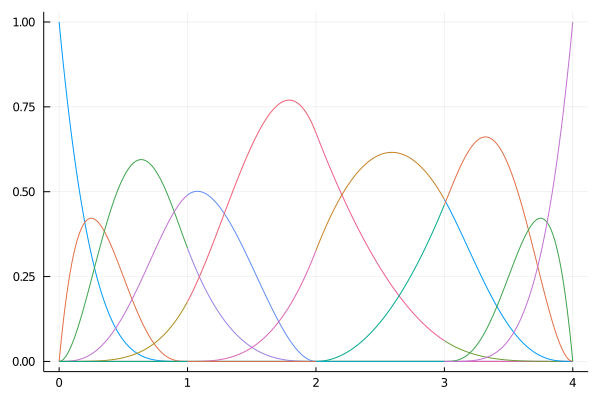

In [25]:
# Mesh([degrees], [continuities])
mesh = Mesh([4, 3, 2, 4], [2, 1, 2])
N = buildSplineBasis( mesh )
plt = Plots.plot( legend = false )
plotSplineBasis!( plt, mesh, N )
plt